In [24]:
import torch
from torch.utils.data import Dataset, DataLoader
import json
from torch.nn.utils.rnn import pad_sequence,pack_padded_sequence,pad_packed_sequence
import torch.nn as nn # for network layers
import math
from sklearn.metrics import confusion_matrix
import sklearn.ensemble
import sklearn.metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# 1.dataset

In [2]:
class myDataset(Dataset):
    def __init__(self,file_content):
        # create synthetic dataset
        labels=[]
        self.features=[]
        for a in file_content:
            labels.append(int(file_content[a]['label']))
            feat = file_content[a]['features']
            features_temp = []
            for b in feat:
                maxx=max(feat[b])   #normalization
                minn=min(feat[b])
                feat_scale=[ (i-minn)/(maxx-minn) for i in feat[b] ]
                #print(max(feat_scale),min(feat_scale))
                features_temp.append(feat_scale) #25*n
            features_temp = torch.transpose(torch.FloatTensor(features_temp), 0, 1)  #n*25
            #features_temp=torch.Tensor(features_temp).transpose(0,1)
            self.features.append(features_temp)
        #self.label=
        self.onehot_labels = torch.zeros(len(labels), 2).scatter_(1, torch.tensor(labels).unsqueeze(1), 1)

    def __len__(self):
        return len(self.onehot_labels)#,len(self.features[0]),len(self.features[0][0])

    def __getitem__(self, index):
        return self.onehot_labels[index], self.features[index]


# 2.model

In [3]:

class MyModel_LSTM(nn.Module):

    def __init__(self,input_size=25,output_size=2):
        super(MyModel_LSTM, self).__init__()  # father class: torch.nn.Module
        drop_prob = 0.5  # dropout
        self.lstm = nn.LSTM(         # 56706
            input_size=input_size,
            hidden_size=64,         # rnn hidden unit
            num_layers=2,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
            dropout=drop_prob,            #wx: x and hidden layer
            bidirectional=True
            
        )
        for name, param in self.lstm.named_parameters():
            nn.init.uniform_(param, -0.1, 0.1)
            
        self.fc = nn.Linear(64*2, output_size)  #has ten output num
        
        #self.sigm = nn.Sigmoid()
        self.dropout = nn.Dropout(0.4) #drop_prob

    def forward(self, features_datas):
        # forward pass (with sigmoid activations) will be called on self()
        lstm_out, _ = self.lstm(features_datas, None) # None represents zero initial hidden state
        output_padded, output_lengths = pad_packed_sequence(lstm_out, batch_first=True) #, enforce_sorted=False )
        
        out1, out2 = torch.chunk(output_padded, 2, dim=2)
        
        out1=out1[range(len(output_lengths)),output_lengths-1]
        out2=out2[range(len(output_lengths)),0]
        out_cat = torch.cat((out1, out2), 1)
        
        output= self.dropout(out_cat)
        out = self.fc( output )
        #sigm_out=self.sigm(out)
        return out #sigm_out

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [5]:
def check_val_accuracy(loader, model, criterion):
    losses = []
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x,y,l in loader:
            x=x.to(device)
            y=y.to(device)
            pack_features = pack_padded_sequence(x, l, batch_first=True, enforce_sorted=False)
            scores = model(pack_features)
            loss = criterion(scores, y)
            losses.append(loss.item())
            _, predictions = scores.max(1)  # max out of those 10 digits
            #_,y= y.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)  # 64 -> batch size


    mean_loss = sum(losses) / len(losses)
    accuracy = float(num_correct) / float(num_samples) * 100
    print(f'Validation loss: {mean_loss:.5f}, accuracy: {accuracy :.2f}' )
    model.train()
    return mean_loss, accuracy

# 3.evaluation

### 1).data

In [65]:
filepath = 'new_lld/lld_test_list.json' 
with open(filepath, 'r') as f:
    file_data = json.load(f)
f.close()
test_data=myDataset(file_data)
print('val and test data:',len(test_data))

val and test data: 1436


In [9]:
def check_ratio(label_data):
    num0=0
    num1=0
    for i in label_data:
        if i==0:
            num0+=1
        else:
            num1+=1
    print('class0:',num0/len(label_data), 'class1:',num1/len(label_data),num0,num1 )

In [12]:
print(type(file_data))

<class 'dict'>


In [69]:
num=0
thefile=[]
for i,j in file_data.items():
    thefile.append(i)
print(len(thefile))

1436


### 2).code

In [59]:
# test code:
def eval_data(test_loader):
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()  # loss function
    print(len(test_loader))
    len_test = len(test_loader)

    losses = []
    num_correct = 0
    num_samples = 0
    prediction_all=[]
    targets_all=[]
    num=0
    thewrong0=[]
    thewrong1=[]
    for features_datas,labels,lengths in test_loader:
        print(len_test)
        len_test -= 1
        #remove padding
        pack_features = pack_padded_sequence(features_datas, lengths, batch_first=True, enforce_sorted=False)

        # forward
        prediction = model(pack_features.float()) #type <class 'torch.Tensor'>
        loss = criterion(prediction, labels)
        losses.append(loss.item())
        _, predictions_index = prediction.max(1)  # max out of those 10 digits
        _, targets_index= labels.max(1)
        #targets_index=labels
        
        print(predictions_index,'\n',targets_index)
        num_correct += (predictions_index == targets_index).sum()
        num_samples += predictions_index.size(0)  # 64 -> batch size
        print(num_correct,num_samples)
        mean_loss = sum(losses) / len(losses)
        accuracy = float(num_correct) / float(num_samples) * 100
        print(f'Training loss: {mean_loss:.5f}, accuracy: {accuracy:.2f}' )
        prediction_all.append(predictions_index)
        targets_all.append(targets_index)
        
    return prediction_all, targets_all,thewrong0,thewrong1


### 3).test with bilstm train with original data

In [15]:
model = MyModel_LSTM(41,2)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

check_dict=torch.load('model-bilstm-all.ph',map_location=None) #model-bilstm-all.ph model-oversampling.ph
model.load_state_dict(check_dict['model'])

<All keys matched successfully>

In [54]:
batch_size = 359

In [55]:
#print(torch.cuda.is_available())

In [56]:
def collate(batch):  #to padding the features data
    labels=[]
    features_all=[]
    features_length=[]
    for i in batch:
        labels.append(i[0]) #(label)
        features_all.append(i[1]) #(features)
        features_length.append(len(i[1])) #(torch.LongTensor(len(features)))
    pad_features = pad_sequence(features_all, batch_first=True, padding_value=0)
    batch_of_labels=torch.stack(labels)
    batch_of_lengths=torch.Tensor(features_length)
    return pad_features,batch_of_labels,batch_of_lengths

In [57]:
test_loader= DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False , drop_last=True, collate_fn=collate)

#### accuracy

In [60]:
prediction_all_test2, targets_all_test2,thewrong0,thewrong1=eval_data(test_loader) 

4
4
tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
        1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
        1, 1, 0, 1, 0, 0, 0, 1, 0, 0

#### confusion matrix

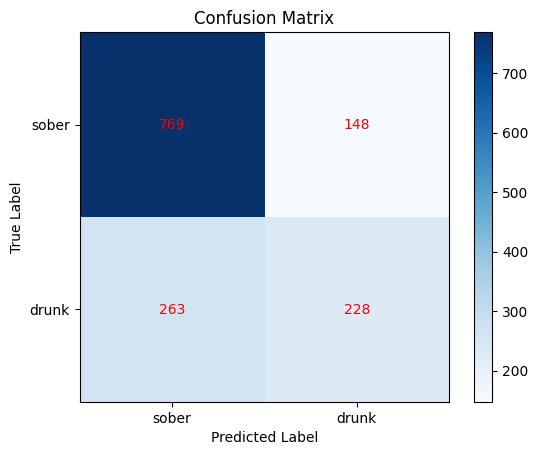

In [35]:
y_true=[]
for i in targets_all_test:
    for j in i:
        #print(int(j),type(int(j)))
        y_true.append(j)
        
y_pred=[]
for i in prediction_all_test:
    for j in i:
        #print(int(j),type(int(j)))
        y_pred.append(j)
        
confusion_mat = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(confusion_mat)

In [52]:
print(len(targets_all_test))
print(len(prediction_all_test))

22
22


In [61]:
truey=[]
predy=[]
for i in targets_all_test2:
    for j in i:
        #print(int(j),type(int(j)))
        truey.append(int(j))
for i in prediction_all_test2:
    for j in i:
        #print(int(j),type(int(j)))
        predy.append(int(j))

In [62]:
prec, rec, f1, _ = sklearn.metrics.precision_recall_fscore_support(
   truey,predy, average=None 
)
print("Precision:", prec)
print("Recall:", rec)
print("F1-score:", f1)

Precision: [0.74882849 0.62059621]
Recall: [0.85090522 0.46076459]
F1-score: [0.79661017 0.52886836]


#### styles of speech analysis

In [64]:
thewrong0=[]
thewrong1=[]
print(len(truey),len(predy))
for i in range(len(truey)):
    if truey[i]!=predy[i]:
        if truey[i]==0:
            thewrong0.append(i)
        else:
            thewrong1.append(i)
print(thewrong0)
print(thewrong1)    

1436 1436
[12, 26, 28, 29, 32, 33, 39, 41, 44, 46, 55, 72, 87, 88, 108, 110, 127, 133, 135, 137, 152, 156, 158, 180, 201, 221, 224, 225, 226, 234, 250, 258, 259, 261, 262, 271, 287, 288, 289, 291, 295, 305, 309, 325, 331, 337, 351, 356, 361, 374, 375, 384, 404, 439, 446, 470, 485, 494, 495, 521, 546, 564, 573, 574, 575, 580, 581, 598, 611, 625, 629, 636, 637, 639, 640, 653, 697, 709, 711, 712, 718, 719, 720, 735, 753, 769, 772, 782, 783, 788, 789, 801, 802, 830, 871, 873, 885, 951, 962, 1007, 1058, 1073, 1074, 1079, 1088, 1098, 1127, 1178, 1179, 1192, 1197, 1206, 1223, 1229, 1248, 1249, 1251, 1272, 1282, 1298, 1300, 1302, 1323, 1330, 1337, 1338, 1341, 1345, 1346, 1355, 1356, 1358, 1360, 1366, 1367, 1379, 1385, 1412, 1415, 1431]
[0, 1, 8, 21, 22, 23, 25, 50, 56, 57, 58, 59, 66, 67, 70, 76, 84, 86, 96, 104, 114, 142, 172, 178, 184, 185, 186, 194, 206, 211, 223, 235, 236, 243, 266, 277, 285, 292, 293, 317, 318, 326, 328, 335, 336, 347, 366, 367, 368, 369, 378, 379, 380, 381, 386, 399, 408

In [101]:
wrongfile0=[]
for i in thewrong0:
    wrongfile0.append(thefile[i])

wrongfile1=[]
for j in thewrong1:
    wrongfile1.append(thefile[j])

In [82]:
read_a = ['001','003', '004', '006', '007', '008','009', '011', '012', '013', '015', '016', '017', '019','020','021','023','024','029','030'] #read numbers, address, words, sentences, credit card numbers, auto numbers
spontaneous_a = ['002', '014', '005','010','018'] 
command_control_a = ['022','025','026','027','028'] 

read_na = ['001','003','004','006','007','008','009','011','012','013','015', '016', '017', '019','020','021','023','024','026','027','028', '031','032','033','035','036','037','039','040','041','044','050','051','052','056','057','058','059','060','029']
spontaneous_na = ['002','014','022','034', '005', '010', '018','025','030','038'] 
command_control_na = ['042','043','045','046','047','048','049','053','054','055']

In [114]:
def print3classes(wrongfile0,wrongfile1):
    lrna=0
    lsna=0
    lcna=0
    lra=0
    lsa=0
    lca=0
    lennum0=0
    lennum1=0
    for i in thefile: #print(i[3],i[7:10])
        if i[3]=='2' or i[3]=='4': #na
            if i[7:10] in spontaneous_na :
                lsna+=1
            elif i[7:10] in command_control_na:
                lcna+=1
            elif i[7:10] in read_na:
                lrna+=1
            else:
                print(i)
            lennum0+=1
        if i[3]=='1' or i[3]=='3': #a
            if i[7:10] in spontaneous_a :
                lsa+=1
            elif i[7:10] in command_control_a:
                lca+=1
            elif i[7:10] in read_a:
                lra+=1
            else:
                print(i)
            lennum1+=1

    print(lrna,lsna,lcna)
    print(lrna/lennum0,lsna/lennum0,lcna/lennum0)
    print(lra,lsa,lca)
    print(lra/lennum1,lsa/lennum1,lca/lennum1)
    print(lennum0,lennum1)
    print()
    
    print(len(wrongfile0))
    lennum=len(wrongfile0)
    rna=0
    sna=0
    cna=0
    for i in wrongfile0: #sober
        #print(i[3],i[7:10])
        if i[7:10] in spontaneous_na :
            sna+=1
        elif i[7:10] in command_control_na:
            cna+=1
        elif i[7:10] in read_na:
            rna+=1
        else:
            print(i)
    print(rna,sna,cna)
    print(rna/lennum,sna/lennum,cna/lennum)
    print(1-rna/lrna,1-sna/lsna,1-cna/lcna)

    print(len(wrongfile1))
    lennum=len(wrongfile1)
    ra=0
    sa=0
    ca=0
    for i in wrongfile1: #sober
        if i[7:10] in spontaneous_a :
            sa+=1
        elif i[7:10] in command_control_a:
            ca+=1
        elif i[7:10] in read_a:
            ra+=1
        else:
            print(i)
    print(ra,sa,ca)
    print(ra/lennum,sa/lennum,ca/lennum)
    print(1-ra/lra,1-sa/lsa,1-ca/lca)
    print()
    
    print('total')
    print(1-((rna+ra)/(lrna+lra)),1-((sna+sa)/(lsna+lsa)),1-((cna+ca)/(lcna+lca)))
    print((lrna+lra),(lsna+lsa),(lcna+lca))

In [115]:
print3classes(wrongfile0,wrongfile1)

635 145 159
0.6762513312034079 0.154419595314164 0.16932907348242812
322 82 93
0.647887323943662 0.16498993963782696 0.18712273641851107
939 497

140
101 20 19
0.7214285714285714 0.14285714285714285 0.1357142857142857
0.8409448818897638 0.8620689655172413 0.8805031446540881
268
166 49 53
0.6194029850746269 0.1828358208955224 0.19776119402985073
0.484472049689441 0.4024390243902439 0.4301075268817204

total
0.7210031347962382 0.696035242290749 0.7142857142857143
957 227 252


### 4). test with bilstm train with oversampling data

In [116]:
model = MyModel_LSTM(41,2)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

check_dict=torch.load('model-oversampling.ph',map_location=None) #model-bilstm-all.ph model-oversampling.ph
model.load_state_dict(check_dict['model'])

<All keys matched successfully>

#### accuracy

In [117]:
prediction_all_test, targets_all_test,thewrong0,thewrong1=eval_data(test_loader) #accuracy:58.72 。 68.89

4
4
tensor([0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 0

#### confusion matrix

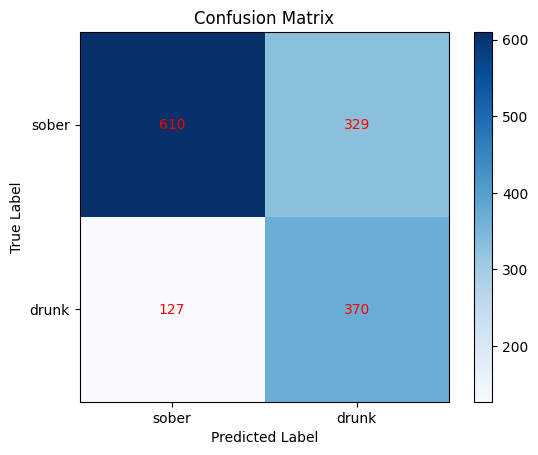

In [118]:
y_true=[]
for i in targets_all_test:
    for j in i:
        #print(int(j),type(int(j)))
        y_true.append(j)
        
y_pred=[]
for i in prediction_all_test:
    for j in i:
        #print(int(j),type(int(j)))
        y_pred.append(j)
        
confusion_mat = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(confusion_mat)

In [119]:
truey=[]
predy=[]
for i in targets_all_test:
    for j in i:
        #print(int(j),type(int(j)))
        truey.append(int(j))
for i in prediction_all_test:
    for j in i:
        #print(int(j),type(int(j)))
        predy.append(int(j))

prec, rec, f1, _ = sklearn.metrics.precision_recall_fscore_support(
   truey,predy, average=None 
)
print("Precision:", prec)
print("Recall:", rec)
print("F1-score:", f1)

Precision: [0.82767978 0.52932761]
Recall: [0.64962726 0.7444668 ]
F1-score: [0.72792363 0.6187291 ]


#### styles of speech analysis

In [120]:
thewrong0=[]
thewrong1=[]
print(len(truey),len(predy))
for i in range(len(truey)):
    if truey[i]!=predy[i]:
        if truey[i]==0:
            thewrong0.append(i)
        else:
            thewrong1.append(i)
print(thewrong0)
print(thewrong1)    

wrongfile0=[]
for i in thewrong0:
    wrongfile0.append(thefile[i])

wrongfile1=[]
for j in thewrong1:
    wrongfile1.append(thefile[j])

1436 1436
[4, 14, 26, 28, 29, 30, 31, 33, 36, 39, 40, 41, 43, 44, 45, 46, 52, 55, 60, 72, 74, 87, 88, 90, 98, 100, 102, 103, 108, 109, 111, 115, 116, 117, 118, 127, 131, 134, 135, 137, 145, 146, 147, 149, 150, 155, 156, 157, 159, 160, 169, 174, 175, 177, 179, 180, 181, 189, 198, 202, 207, 210, 214, 224, 226, 227, 233, 234, 240, 256, 258, 260, 261, 262, 263, 271, 272, 275, 278, 287, 288, 289, 290, 291, 295, 296, 304, 305, 306, 307, 309, 322, 324, 325, 331, 332, 340, 344, 349, 351, 355, 356, 372, 373, 375, 383, 384, 389, 391, 392, 393, 396, 402, 404, 412, 430, 439, 446, 449, 450, 464, 466, 467, 470, 476, 477, 484, 492, 493, 498, 504, 506, 546, 547, 550, 551, 559, 564, 565, 569, 573, 574, 575, 576, 578, 580, 581, 582, 589, 597, 598, 604, 605, 608, 610, 613, 615, 616, 624, 627, 629, 635, 637, 638, 639, 640, 644, 646, 653, 669, 681, 688, 695, 696, 697, 698, 707, 711, 712, 717, 718, 719, 720, 722, 727, 728, 730, 735, 736, 743, 748, 752, 753, 754, 760, 762, 771, 772, 782, 783, 788, 794, 801, 

In [121]:
print3classes(wrongfile0,wrongfile1)

635 145 159
0.6762513312034079 0.154419595314164 0.16932907348242812
322 82 93
0.647887323943662 0.16498993963782696 0.18712273641851107
939 497

329
204 66 59
0.6200607902735562 0.2006079027355623 0.17933130699088146
0.6787401574803149 0.5448275862068965 0.628930817610063
127
77 23 27
0.6062992125984252 0.18110236220472442 0.2125984251968504
0.7608695652173914 0.7195121951219512 0.7096774193548387

total
0.7063740856844305 0.6079295154185023 0.6587301587301587
957 227 252
